# Artificial data

Methods:
1. Logistic regression with L1 regularization
2. Random Forest Classifier features importance
3. Correlation matrix (leave only around 10 least correlated features)
4. Boruta (Random Forest Classifier) with correlation matrix afterwards

For each method, an XGBoost classifier was trained on the selected features and the accuracy was calculated. This model was chosen after performing initial experiments to compare different models.

# Loading data

In [1]:
import pandas as pd

artificial_train = pd.read_csv('data/artificial_train.data', sep=' ', header=None).dropna(axis=1)
artificial_train_labels = pd.read_csv('data/artificial_train.labels', sep=' ', header=None).dropna(axis=1)
artificial_train_labels = (artificial_train_labels[0].values+1)/2
artificial_test = pd.read_csv('data/artificial_valid.data', sep=' ', header=None).dropna(axis=1)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(artificial_train, artificial_train_labels, test_size=0.2, random_state=42)
X_train, X_valid = X_train.values, X_valid.values

## Preprocessing - scaling ( for some methods )

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
artificial_test_scaled = scaler.transform(artificial_test)

# Feature selection

## Logistic regression with L1 loss

In [4]:
import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

list_of_regularisation_values = [0.03, 0.06, 0.1, 0.2, 0.3, 0.6]
list_of_accuracies_valid = []
list_of_accuracies_train = []
list_of_numbers_of_features = []
for regularisation_value in tqdm.tqdm(list_of_regularisation_values):
    lr = LogisticRegression(C=regularisation_value, random_state=1, penalty='l1', solver='liblinear')
    lr.fit(X_train_scaled, y_train)
    y_train_pred = lr.predict(X_train_scaled)
    y_valid_pred = lr.predict(X_valid_scaled)
    list_of_accuracies_valid.append(accuracy_score(y_valid, y_valid_pred))
    list_of_accuracies_train.append(accuracy_score(y_train, y_train_pred))
    list_of_numbers_of_features.append(sum(lr.coef_[0] != 0))

100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


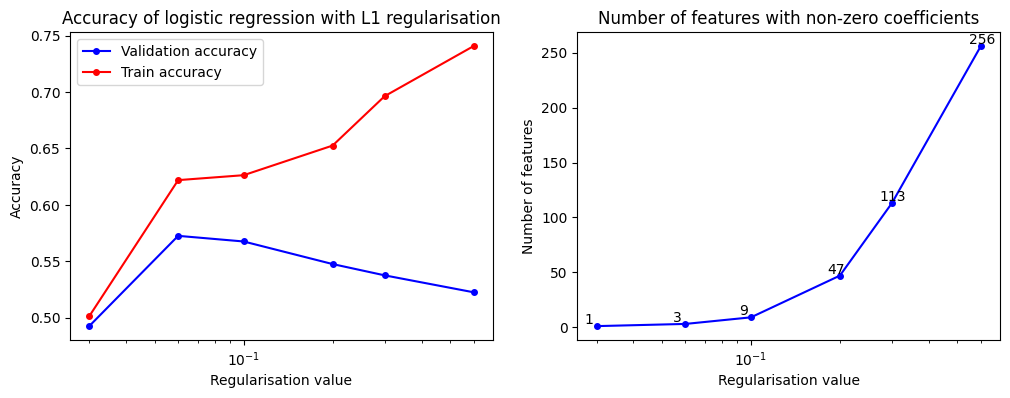

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot accuracy wrt penalty value
ax[0].plot(list_of_regularisation_values, list_of_accuracies_valid, 'o-', label='Validation accuracy', color='blue', markersize=4)
ax[0].plot(list_of_regularisation_values, list_of_accuracies_train, 'o-', label='Train accuracy', color='red', markersize=4)
ax[0].set_xscale('log')
ax[0].set_title('Accuracy of logistic regression with L1 regularisation')
ax[0].set_xlabel('Regularisation value')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# plot number of features wrt penalty value
ax[1].plot(list_of_regularisation_values, list_of_numbers_of_features, 'o-', color='blue', markersize=4)
# add number to each dot
for i, txt in enumerate(list_of_numbers_of_features):
    ax[1].annotate(txt, (list_of_regularisation_values[i]/1.1, list_of_numbers_of_features[i]+2))
ax[1].set_xscale('log')
ax[1].set_title('Number of features with non-zero coefficients')
ax[1].set_xlabel('Regularisation value')
ax[1].set_ylabel('Number of features')
plt.show()

### XGBoost on the few features selected by L1 regularization with logistic regression

For regularization value 0.1.

In [29]:
lr = LogisticRegression(C=0.1, random_state=1, penalty='l1', solver='liblinear')
lr.fit(X_train_scaled, y_train)
X_train_filtered_small = X_train[:, lr.coef_[0] != 0]
X_valid_filtered_small = X_valid[:, lr.coef_[0] != 0]

100%|██████████| 24/24 [00:04<00:00,  5.94it/s]


Best score was for depth 18 and is 0.662


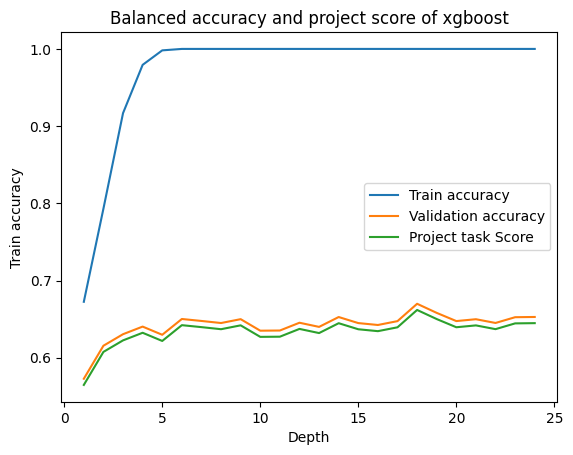

In [31]:
# xgboost
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

list_of_dicts = []
for i in tqdm.tqdm(range(1, 25)):
    rf = XGBClassifier(n_estimators=100, max_depth=i, random_state=1)
    rf.fit(X_train_filtered_small, y_train)
    y_train_pred = rf.predict(X_train_filtered_small)
    acc_train = balanced_accuracy_score(y_train, y_train_pred)
    y_valid_pred = rf.predict(X_valid_filtered_small)
    acc_valid = balanced_accuracy_score(y_valid, y_valid_pred)
    list_of_dicts.append({'Depth': i,
                          'Train accuracy': acc_train,
                          'Validation accuracy': acc_valid,
                          'Project task Score' : acc_valid - 0.01 * max(0, 1/5 * X_train_filtered_small.shape[1] - 1)})
    
import seaborn as sns
df = pd.DataFrame(list_of_dicts)
print(f'Best score was for depth {df.iloc[df["Project task Score"].argmax()]["Depth"]:.0f} and is {df["Project task Score"].max():.3f}')
sns.lineplot(data=df, x='Depth', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=df, x='Depth', y='Validation accuracy', label='Validation accuracy')
sns.lineplot(data=df, x='Depth', y='Project task Score', label='Project task Score')
plt.title('Balanced accuracy and project score of xgboost')
plt.show()

Well, features selected by the logistic regression were not that helpful.

## Random Forest feature importance

Accuracy of random forest on train set: 0.998


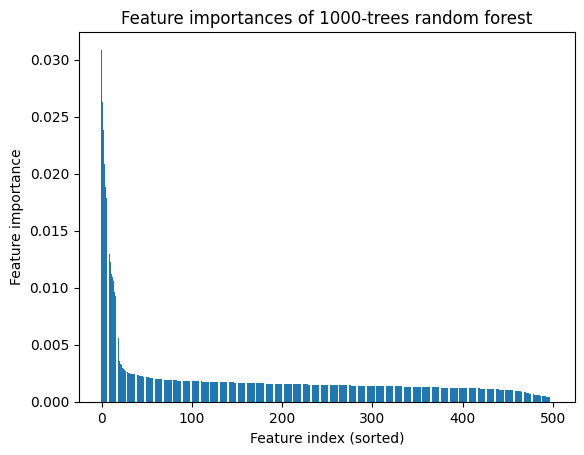

In [6]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

# train random forest
N = 1000
rf = RandomForestClassifier(n_estimators=N, max_depth=7, random_state=1)
rf.fit(X_train, y_train)
print('Accuracy of random forest on train set: {:.3f}'.format(rf.score(X_train, y_train)))
importances = rf.feature_importances_
from matplotlib import pyplot as plt
plt.bar(list(range(len(importances))), sorted(importances, reverse=True))
plt.title(f'Feature importances of {N}-trees random forest')
plt.xlabel('Feature index (sorted)')
plt.ylabel('Feature importance')
plt.show()

Zoom at the first 40 features...

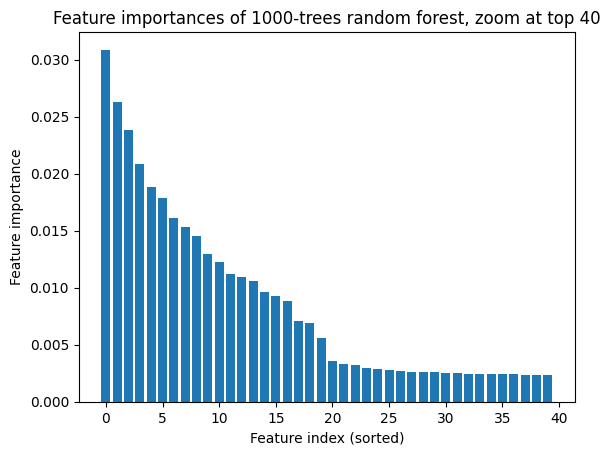

In [7]:
from matplotlib import pyplot as plt
plt.bar(list(range(len(importances)))[:40], sorted(importances, reverse=True)[:40])
plt.title(f'Feature importances of {N}-trees random forest, zoom at top 40')
plt.xlabel('Feature index (sorted)')
plt.ylabel('Feature importance')
plt.show()

Clearly, first 20 features differ from the rest - they have visibly different importance.

### XGBoost based on top features only

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

list_of_dicts = []
for i in tqdm.tqdm(range(1, 25)):
    list_of_features = list(importances.argsort()[-i:])
    rf = XGBClassifier(n_estimators=100, max_depth=20, random_state=1)
    rf.fit(X_train[:, list_of_features], y_train)
    y_train_pred = rf.predict(X_train[:, list_of_features])
    acc_train = balanced_accuracy_score(y_train, y_train_pred)
    y_valid_pred = rf.predict(X_valid[:, list_of_features])
    acc_valid = balanced_accuracy_score(y_valid, y_valid_pred)
    list_of_dicts.append({'Number of features': i,
                          'Train accuracy': acc_train,
                          'Validation accuracy': acc_valid,
                          'Project task Score' : acc_valid - 0.01 * max(0, 1/5 * i - 1)})

100%|██████████| 24/24 [00:09<00:00,  2.47it/s]


Best score was for 18 features and is 0.869


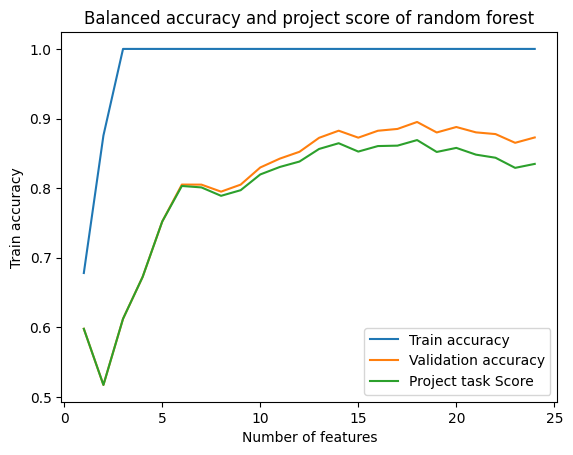

In [9]:
import seaborn as sns

df = pd.DataFrame(list_of_dicts)
print(f'Best score was for {df.iloc[df["Project task Score"].argmax()]["Number of features"]:.0f} features and is {df["Project task Score"].max():.3f}')

sns.lineplot(data=df, x='Number of features', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=df, x='Number of features', y='Validation accuracy', label='Validation accuracy')
sns.lineplot(data=df, x='Number of features', y='Project task Score', label='Project task Score')
plt.title('Balanced accuracy and project score of random forest')
plt.show()

## Correlation matrix feature selection

Maybe all unimportant features were created based on the original few important ones - they could be highly correlated with each other so let's try removing them this way.

Removing features with correlation higher than 0.04 (value selected manually to leave less than 10 features).

Number of features after filtering: 8


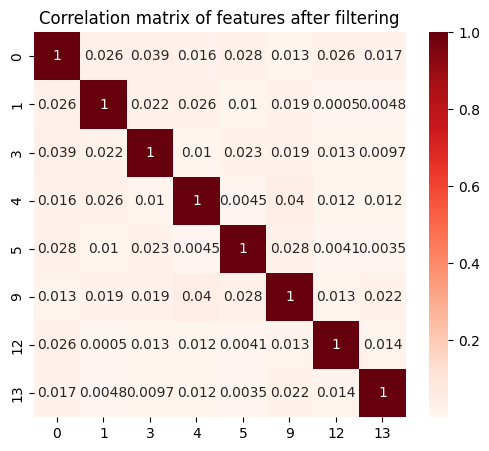

In [19]:
import numpy as np
np.bool = bool

corr_matrix = pd.DataFrame(X_train).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.04)]
df_X_train_filtered = pd.DataFrame(X_train)
df_X_train_filtered.drop(to_drop, axis=1, inplace=True)
X_train_filtered_small = df_X_train_filtered.values
df_X_valid_filtered = pd.DataFrame(X_valid)
df_X_valid_filtered.drop(to_drop, axis=1, inplace=True)
X_valid_filtered_small = df_X_valid_filtered.values
print(f'Number of features after filtering: {X_train_filtered_small.shape[1]}')

corr_filtered = df_X_train_filtered.corr().abs()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_filtered, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation matrix of features after filtering')
plt.show()

### XGBoost based on data filtered by correlation matrix only

100%|██████████| 24/24 [00:09<00:00,  2.60it/s]


Best score was for depth 7 and is 0.539


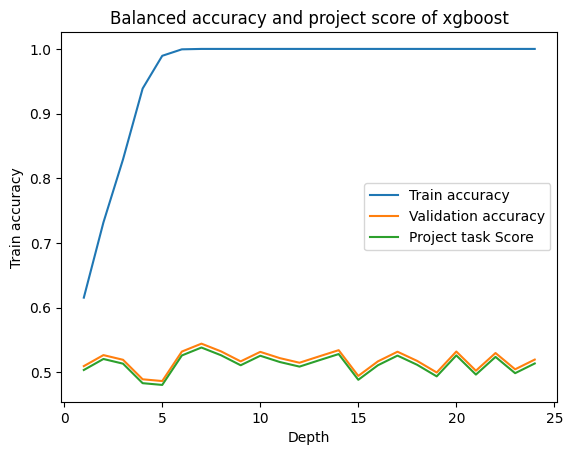

In [21]:
# xgboost
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

list_of_dicts = []
for i in tqdm.tqdm(range(1, 25)):
    rf = XGBClassifier(n_estimators=100, max_depth=i, random_state=1)
    rf.fit(X_train_filtered_small, y_train)
    y_train_pred = rf.predict(X_train_filtered_small)
    acc_train = balanced_accuracy_score(y_train, y_train_pred)
    y_valid_pred = rf.predict(X_valid_filtered_small)
    acc_valid = balanced_accuracy_score(y_valid, y_valid_pred)
    list_of_dicts.append({'Depth': i,
                          'Train accuracy': acc_train,
                          'Validation accuracy': acc_valid,
                          'Project task Score' : acc_valid - 0.01 * max(0, 1/5 * X_train_filtered_small.shape[1] - 1)})
    
import seaborn as sns
df = pd.DataFrame(list_of_dicts)
print(f'Best score was for depth {df.iloc[df["Project task Score"].argmax()]["Depth"]:.0f} and is {df["Project task Score"].max():.3f}')
sns.lineplot(data=df, x='Depth', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=df, x='Depth', y='Validation accuracy', label='Validation accuracy')
sns.lineplot(data=df, x='Depth', y='Project task Score', label='Project task Score')
plt.title('Balanced accuracy and project score of xgboost')
plt.show()

Well... it didn't help much. This means, that the important features were removed as well and the unimportant features were not created by simple modification of the important ones. That is why the correlation between them is so low.

## Boruta + correlation matrix feature selection

In [27]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=7, random_state=42, class_weight='balanced', n_jobs=-1)
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
import numpy as np
np.int = int
np.float = float
np.bool = bool
feat_selector.fit(X_train, y_train)
print(f'Number of features selected: {feat_selector.n_features_}')
X_train_filtered = feat_selector.transform(X_train)
X_valid_filtered = feat_selector.transform(X_valid)

Number of features selected: 21


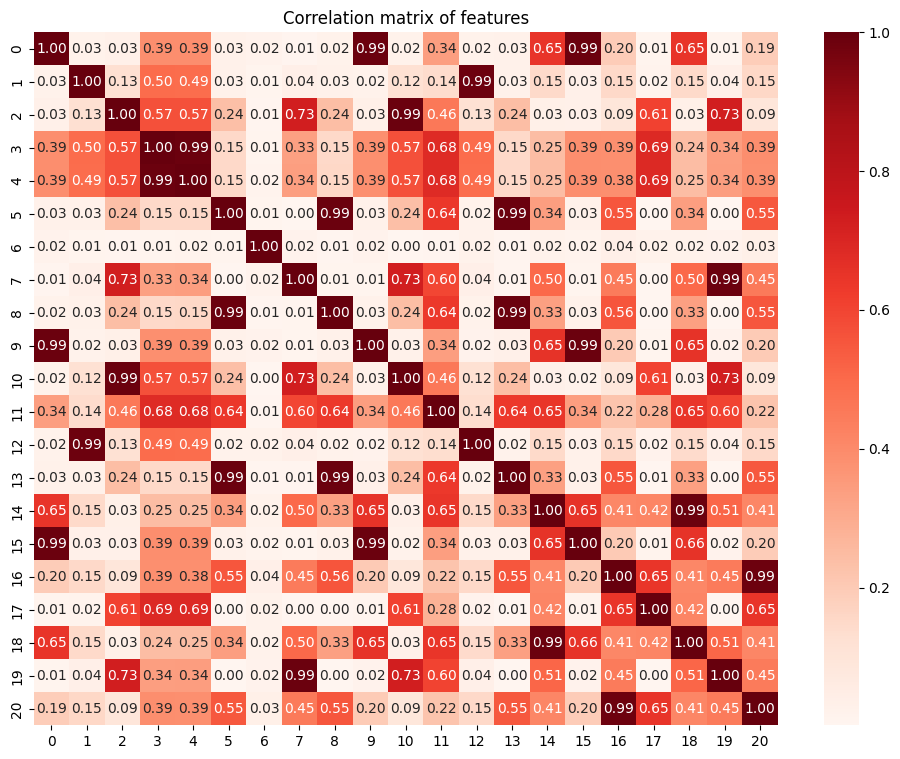

In [37]:
corr_matrix = pd.DataFrame(X_train_filtered).corr().abs()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.title('Correlation matrix of features')
plt.show()

Removing features with correlation > 0.6.

Number of features after filtering: 7


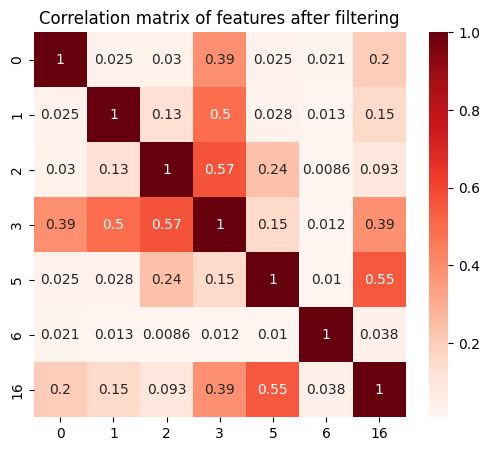

In [86]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
df_X_train_filtered = pd.DataFrame(X_train_filtered)
df_X_train_filtered.drop(to_drop, axis=1, inplace=True)
X_train_filtered_small = df_X_train_filtered.values
df_X_valid_filtered = pd.DataFrame(X_valid_filtered)
df_X_valid_filtered.drop(to_drop, axis=1, inplace=True)
X_valid_filtered_small = df_X_valid_filtered.values
print(f'Number of features after filtering: {X_train_filtered_small.shape[1]}')

corr_filtered = df_X_train_filtered.corr().abs()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_filtered, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation matrix of features after filtering')
plt.show()

## Training models on these 5 features

### XGBoost

100%|██████████| 24/24 [00:09<00:00,  2.52it/s]


Best score was for depth 20 and is 0.871


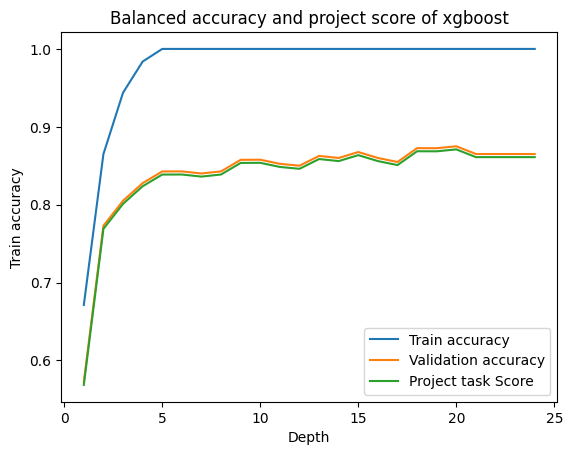

In [87]:
# xgboost
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

list_of_dicts = []
for i in tqdm.tqdm(range(1, 25)):
    rf = XGBClassifier(n_estimators=100, max_depth=i, random_state=1)
    rf.fit(X_train_filtered_small, y_train)
    y_train_pred = rf.predict(X_train_filtered_small)
    acc_train = balanced_accuracy_score(y_train, y_train_pred)
    y_valid_pred = rf.predict(X_valid_filtered_small)
    acc_valid = balanced_accuracy_score(y_valid, y_valid_pred)
    list_of_dicts.append({'Depth': i,
                          'Train accuracy': acc_train,
                          'Validation accuracy': acc_valid,
                          'Project task Score' : acc_valid - 0.01 * max(0, 1/5 * X_train_filtered_small.shape[1] - 1)})
    
import seaborn as sns
df = pd.DataFrame(list_of_dicts)
print(f'Best score was for depth {df.iloc[df["Project task Score"].argmax()]["Depth"]:.0f} and is {df["Project task Score"].max():.3f}')
sns.lineplot(data=df, x='Depth', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=df, x='Depth', y='Validation accuracy', label='Validation accuracy')
sns.lineplot(data=df, x='Depth', y='Project task Score', label='Project task Score')
plt.title('Balanced accuracy and project score of xgboost')
plt.show()

### K Nearest Neighbors Classifier

100%|██████████| 38/38 [00:06<00:00,  5.85it/s]


Best score was for 17 neighbors and is 0.841


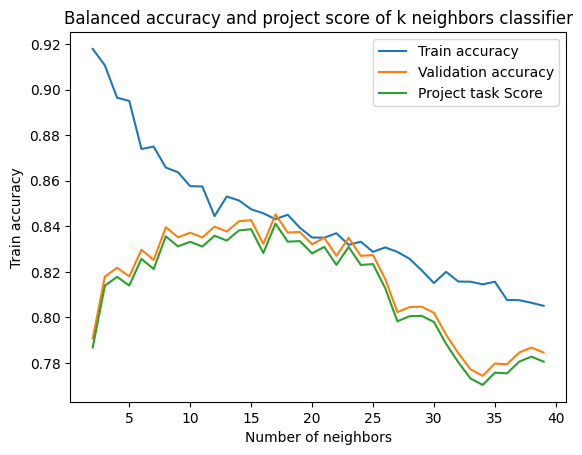

In [88]:
# k neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

list_of_dicts = []
for i in tqdm.tqdm(range(2, 40)):
    rf = KNeighborsClassifier(n_neighbors=i)
    rf.fit(X_train_filtered_small, y_train)
    y_train_pred = rf.predict(X_train_filtered_small)
    acc_train = balanced_accuracy_score(y_train, y_train_pred)
    y_valid_pred = rf.predict(X_valid_filtered_small)
    acc_valid = balanced_accuracy_score(y_valid, y_valid_pred)
    list_of_dicts.append({'Number of neighbors': i,
                          'Train accuracy': acc_train,
                          'Validation accuracy': acc_valid,
                          'Project task Score' : acc_valid - 0.01 * max(0, 1/5 * X_train_filtered_small.shape[1] - 1)})
    
import seaborn as sns
df = pd.DataFrame(list_of_dicts)
print(f'Best score was for {df.iloc[df["Project task Score"].argmax()]["Number of neighbors"]:.0f} neighbors and is {df["Project task Score"].max():.3f}')
sns.lineplot(data=df, x='Number of neighbors', y='Train accuracy', label='Train accuracy')
sns.lineplot(data=df, x='Number of neighbors', y='Validation accuracy', label='Validation accuracy')
sns.lineplot(data=df, x='Number of neighbors', y='Project task Score', label='Project task Score')
plt.title('Balanced accuracy and project score of k neighbors classifier')
plt.show()